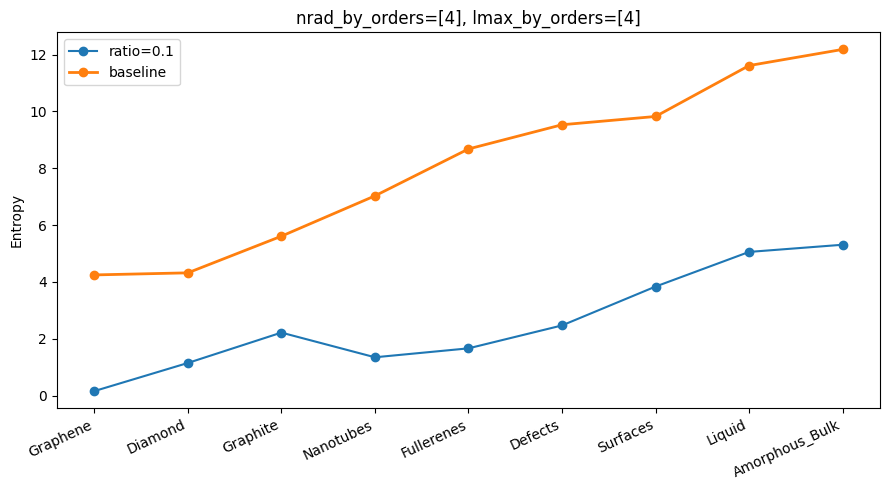

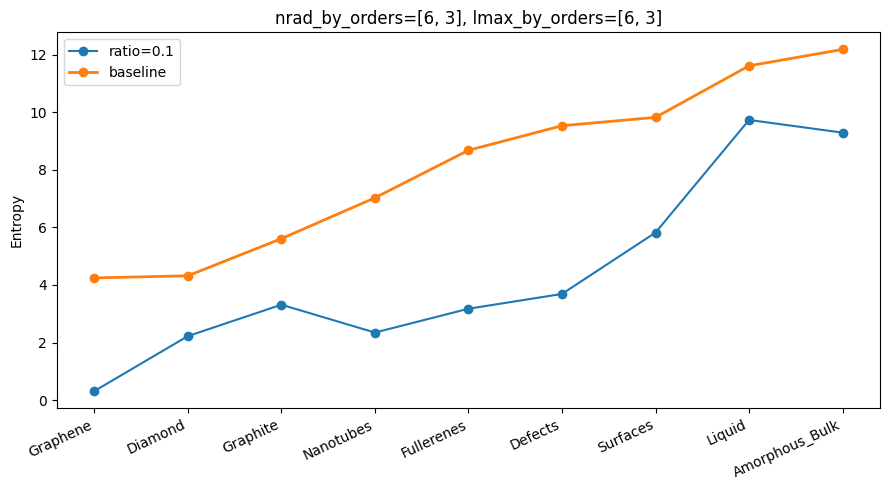

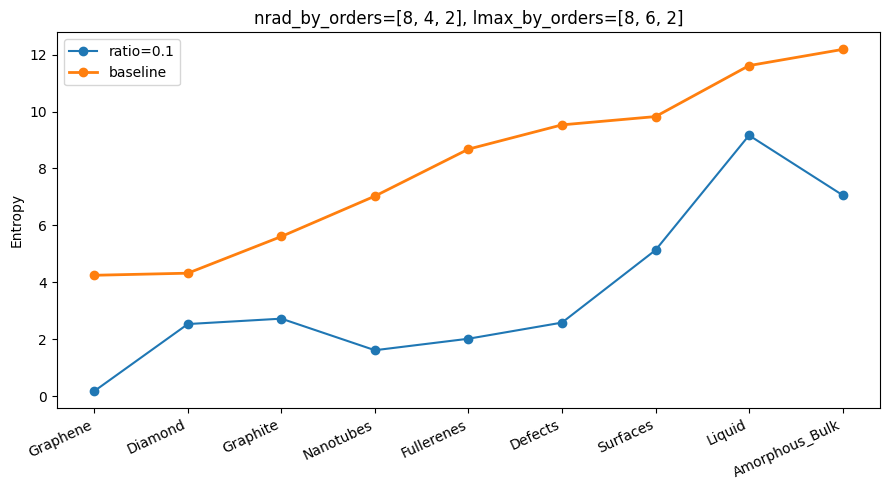

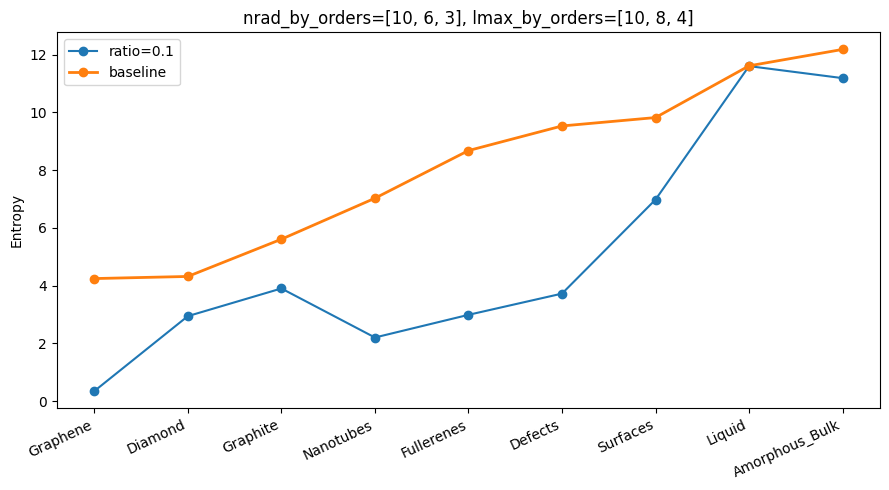

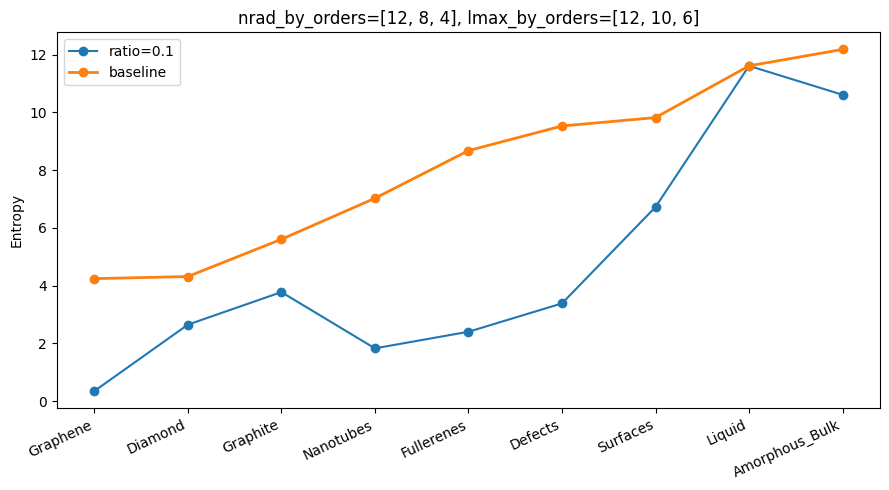

'entropy_plots_all_sweeps.pdf'

In [15]:
# We'll create the plots from the user's JSONL snippet and include the baseline.
# The code also works if you later replace the JSONL content or point it to a larger file.

import json
import os
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt

jsonl_path = "sweep_results/sweep_fcc_multicomponent.jsonl"

# 2) Define the five sweep configurations in the order provided.
sweeps = [
    {"nrad": [4], "lmax": [4]},
    {"nrad": [6, 3], "lmax": [6, 3]},
    {"nrad": [8, 4, 2], "lmax": [8, 6, 2]},
    {"nrad": [10, 6, 3], "lmax": [10, 8, 4]},
    {"nrad": [12, 8, 4], "lmax": [12, 10, 6]},
]

# Helper to turn a sweep dict into a hashable key
def sweep_key(s):
    return (tuple(s["nrad"]), tuple(s["lmax"]))

sweep_keys_in_order = [sweep_key(s) for s in sweeps]

# 3) Parse the JSONL and group entries by sweep key and ratio.
groups = defaultdict(lambda: defaultdict(list))  # groups[(nrad,lmax)][ratio] -> list of entries

with open(jsonl_path, "r") as f:
    for line in f:
        line = line.strip()

        if not line:
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue
        funcs = obj.get("basis_config", {}).get("functions", {}).get("ALL", {})
        nrad = funcs.get("nradmax_by_orders")
        lmax = funcs.get("lmax_by_orders")
        if nrad is None or lmax is None:
            continue
        k = (tuple(nrad), tuple(lmax))
        ratio = round(obj.get("ratio"), 1)
        entropy = obj.get("entropy", {})
        if ratio is not None and entropy:
            groups[k][ratio].append(entropy)

# 4) Baseline entropy (fixing the minor typos by adding the missing colons).
baseline_entropy = OrderedDict([
    ("Graphene", 4.245179458166078),
    ("Diamond", 4.318381910272738),
    ("Graphite", 5.6085074467370095),
    ("Nanotubes", 7.0282707526691715),
    ("Fullerenes", 8.67911004440742),
    ("Defects", 9.531933892473084),
    ("Surfaces", 9.823139796211981),
    ("Liquid", 11.61485589283075),
    ("Amorphous_Bulk", 12.183809856122803),
])

x_labels = list(baseline_entropy.keys())

# 5) Create one plot per sweep (5 total), with curves grouped by ratio + a baseline.
out_paths = []
for idx, key in enumerate(sweep_keys_in_order, start=1):
    plt.figure(figsize=(9, 5))
    
    # Plot each ratio curve (averaging duplicates if any exist).
    ratio_to_entropy = groups.get(key, {})
    for ratio in sorted(ratio_to_entropy.keys()):
        # Compute mean per category if multiple entries for same ratio (shouldn't be necessary but robust).
        sums = {k: 0.0 for k in x_labels}
        cnts = {k: 0 for k in x_labels}
        for ent in ratio_to_entropy[ratio]:
            for kcat in x_labels:
                if kcat in ent:
                    sums[kcat] += ent[kcat]
                    cnts[kcat] += 1
        y_vals = [sums[kcat] / cnts[kcat] if cnts[kcat] > 0 else float('nan') for kcat in x_labels]
        plt.plot(x_labels, y_vals, marker="o", label=f"ratio={ratio}")

    y_base = [baseline_entropy[label] for label in x_labels]
    plt.plot(x_labels, y_base, marker="o", label="baseline", linewidth=2)
    
    # Titles and labels
    title_str = f"nrad_by_orders={list(key[0])}, lmax_by_orders={list(key[1])}"
    plt.title(title_str)
    plt.ylabel("Entropy")
    plt.legend()
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    out_png = f"entropy_plot_sweep_{idx}.png"
    plt.savefig(out_png, dpi=150)
    out_paths.append(out_png)
    plt.show()

# Optionally, save a combined PDF with all figures
from matplotlib.backends.backend_pdf import PdfPages
combined_pdf = "entropy_plots_all_sweeps.pdf"
with PdfPages(combined_pdf) as pdf:
    for path in out_paths:
        img = plt.imread(path)
        plt.figure(figsize=(9,5))
        plt.imshow(img)
        plt.axis("off")
        pdf.savefig(bbox_inches="tight")
        plt.close()

combined_pdf
